In [1]:
from functions import *
from step1_functions import *
from time_stitches import *
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
#function for x dicrimination
def remove_extreme_using_x_pos(nh_rec, tw_rec, prop_nh=0.5, prop_tw=0.5):
    """Create a mask keeping all points which are between two extreme values"""
    nh_threshold_x = (nh_rec['X.1'].max() - nh_rec['X.1'].median())*prop_nh #remove all points above it
    tw_threshold_x = (tw_rec['X.1'].min() - tw_rec['X.1'].median())*prop_tw #remove all points below it

    selected_nh = (nh_rec['X.1']<nh_threshold_x)
    selected_tw = (tw_rec['X.1']>tw_threshold_x)

    return selected_nh, selected_tw

In [3]:
def compute_mask_using_v(nh_rec, tw_rec, smooth_window=60, prop_nh=0.4, prop_tw=0.4):
    """Compute masks to discriminate periods when tools go to extreme positions ie when velocity reaches high/low values. 
        It gives for each tool a mask where velocity is more extreme than a threshold and another where it is lower than another threshold"""
    smooth_vx_nh, smooth_accx_nh = compute_v_acc(nh_rec, smooth_box=smooth_window, smooth_ = True)
    
    smooth_vx_tw, smooth_accx_tw = compute_v_acc(tw_rec, smooth_box=smooth_window, smooth_ = True)

    nh_max_threshold_vx = max(smooth_vx_nh)*prop_nh #initially /2
    nh_min_threshold_vx = min(smooth_vx_nh)*prop_nh
    mask_vx_max_nh = (smooth_vx_nh <nh_max_threshold_vx)
    mask_vx_min_nh = (smooth_vx_nh >nh_min_threshold_vx)

    tw_min_threshold_vx = min(smooth_vx_tw)*prop_tw
    tw_max_threshold_vx = max(smooth_vx_tw)*prop_tw
    mask_vx_min_tw = (smooth_vx_tw > tw_min_threshold_vx)
    mask_vx_max_tw = (smooth_vx_tw < tw_max_threshold_vx)

    return [mask_vx_min_nh, mask_vx_max_nh], [mask_vx_min_tw, mask_vx_max_tw]

In [4]:
def compute_event_time(segments_time_i, selected_data_nh, selected_data_tw, mask_vx_min_nh,  mask_vx_max_nh, mask_vx_min_tw, mask_vx_max_tw):
    start_t_task = segments_time_i['1'][0] #beginning of first stitch
    end_t_task = segments_time_i['8'][1] #end of last stitch

    """Needle Holder"""
    #give the position of last True before changing to False (juste before reaching v threshold to exclude points)
    start_pic_max_nh = list(np.where(np.diff(mask_vx_max_nh.astype(int)) == -1)[0])
    #want the position of the last false before a new True
    end_pic_min_nh = list(np.where(np.diff(mask_vx_min_nh.astype(int)) == 1)[0])

    time_start_pic_max_nh_ = list(selected_data_nh.iloc[start_pic_max_nh]['Time (Seconds)'])
    #remove picks which start before the beginning of the task or after the end of the task
    time_start_pic_max_nh = [x for x in time_start_pic_max_nh_ if ((x >= start_t_task) & (x <= end_t_task))]

    time_end_pic_min_nh_ = list(selected_data_nh.iloc[end_pic_min_nh]['Time (Seconds)'])
    #remove picks which start before the beginning of the task or after the end of the task
    time_end_pic_min_nh = [x for x in time_end_pic_min_nh_ if ((x >= start_t_task) & (x <= end_t_task))]

    """Tweezers"""
    #give the position of last True before changing to False (juste before reaching v threshold to exclude points)
    start_pic_max_tw = list(np.where(np.diff(mask_vx_min_tw.astype(int)) == -1)[0])
    #want the position of the last false before a new True
    end_pic_min_tw = list(np.where(np.diff(mask_vx_max_tw.astype(int)) == 1)[0])

    time_start_pic_max_tw_ = list(selected_data_tw.iloc[start_pic_max_tw]['Time (Seconds)'])
    #remove picks which start before the beginning of the task or after the end of the task
    time_start_pic_max_tw = [x for x in time_start_pic_max_tw_ if ((x >= start_t_task) & (x <= end_t_task))]

    time_end_pic_min_tw_ = list(selected_data_tw.iloc[end_pic_min_tw]['Time (Seconds)'])
    #remove picks which start before the beginning of the task or after the end of the task
    time_end_pic_min_tw = [x for x in time_end_pic_min_tw_ if ((x >= start_t_task) & (x <= end_t_task))]

    return [time_start_pic_max_nh, time_end_pic_min_nh], [time_start_pic_max_tw, time_end_pic_min_tw]

    

In [5]:
#initial version
def compute_pairs_time(time_start_pic_max, time_end_pic_min, delta_t=30):
    pairs = []
    for start in time_start_pic_max:
        delta_t = 30 #delta t max allowed is 30 s
        pair = []
        for end in time_end_pic_min:
            if (((end-start)<(delta_t)) & ((end-start)>0)):
                delta_t = end-start
                pair = [start-0.5, end+0.5] #we allow to take values 0.5s before and after the event time
        if pair: pairs.append(pair)
    return pairs

In [6]:
#version 3
def compute_pairs_time(time_start_pic_max, time_end_pic_min, delta_t=60):
    pairs = []
    for start in (time_start_pic_max):
        end_times = np.array(time_end_pic_min)
        later_than_start = end_times[end_times>start]
        if (len(later_than_start)!=0):
            closest_end_time = later_than_start[(later_than_start-start).argmin()]
            if ((closest_end_time-start)<delta_t): 
                pairs.append([start-0.5, closest_end_time+0.5])
    return pairs

In [7]:
def remove_extreme_using_v_time(selected_data, pairs_t):
    """Return a mask of values to keep ie values that are not in the interval where velocity reaches extreme values"""
    mask = np.ones(len(selected_data), dtype=bool) 
    for t_start, t_end in pairs_t:
        mask &= (selected_data['Time (Seconds)'] < (t_start)) | (selected_data['Time (Seconds)'] > (t_end ))
    return mask

In [8]:
def adjust_time_pair(data, pairs, median_x, time_allowed = 3):
    new_pairs = []
    for start, end in pairs:
        interval_min = start - time_allowed/2
        interval_max = end + time_allowed/2

        #initialise in case we don't have new start/end
        new_start = start 
        new_end = end

        data_before = data[(data['Time (Seconds)']>interval_min) & (data['Time (Seconds)']<start)].reset_index(drop=True)
        data_after = data[(data['Time (Seconds)']>end) & (data['Time (Seconds)']<interval_max)].reset_index(drop=True)

        condition_b = np.abs(data_before['X.1']-median_x)<0.005
        if (np.sum(condition_b)>0):
            # we want the last time where we were close to the ref line (ie median)
            new_start_index = (data_before[condition_b]['X.1']).argmax() 
            new_start = data_before.loc[int(new_start_index)]['Time (Seconds)']

        condition_a = np.abs(data_after['X.1']-median_x)<0.005
        if (np.sum(condition_a)>0):
            # we want the first time we are cross the ref line (ie median)
            new_end_index = (data_after[condition_a]['X.1']).argmin()
            new_end = data_after.loc[int(new_end_index)]['Time (Seconds)']

        new_pairs.append([new_start, new_end])
    return new_pairs


In [9]:
def compute_event_time_x_pos(segments_time_i, selected_data_nh, selected_data_tw, mask_x_nh, mask_x_tw):
    start_t_task = segments_time_i['1'][0] #beginning of first stitch
    end_t_task = segments_time_i['8'][1] #end of last stitch

    """Needle Holder"""
    #give the position of last True before changing to False (juste before reaching v threshold to exclude points)
    start_pic_max_nh = list(np.where(np.diff(mask_x_nh.astype(int)) == -1)[0])
    #want the position of the last false before a new True
    end_pic_min_nh = list(np.where(np.diff(mask_x_nh.astype(int)) == 1)[0])

    time_start_pic_max_nh_ = list(selected_data_nh.iloc[start_pic_max_nh]['Time (Seconds)'])
    #remove picks who start before the beginning of the task or after the end of the task
    time_start_pic_max_nh = [x for x in time_start_pic_max_nh_ if ((x >= start_t_task) & (x <= end_t_task))]

    time_end_pic_min_nh_ = list(selected_data_nh.iloc[end_pic_min_nh]['Time (Seconds)'])
    #remove picks who start before the beginning of the task or after the end of the task
    time_end_pic_min_nh = [x for x in time_end_pic_min_nh_ if ((x >= start_t_task) & (x <= end_t_task))]

    """Tweezers"""
    #give the position of last True before changing to False (juste before reaching v threshold to exclude points)
    start_pic_max_tw = list(np.where(np.diff(mask_x_tw.astype(int)) == -1)[0])
    #want the position of the last false before a new True
    end_pic_min_tw = list(np.where(np.diff(mask_x_tw.astype(int)) == 1)[0])

    time_start_pic_max_tw_ = list(selected_data_tw.iloc[start_pic_max_tw]['Time (Seconds)'])
    #remove picks who start before the beginning of the task or after the end of the task
    time_start_pic_max_tw = [x for x in time_start_pic_max_tw_ if ((x >= start_t_task) & (x <= end_t_task))]

    time_end_pic_min_tw_ = list(selected_data_tw.iloc[end_pic_min_tw]['Time (Seconds)'])
    #remove picks who start before the beginning of the task or after the end of the task
    time_end_pic_min_tw = [x for x in time_end_pic_min_tw_ if ((x >= start_t_task) & (x <= end_t_task))]

    return [time_start_pic_max_nh, time_end_pic_min_nh], [time_start_pic_max_tw, time_end_pic_min_tw]

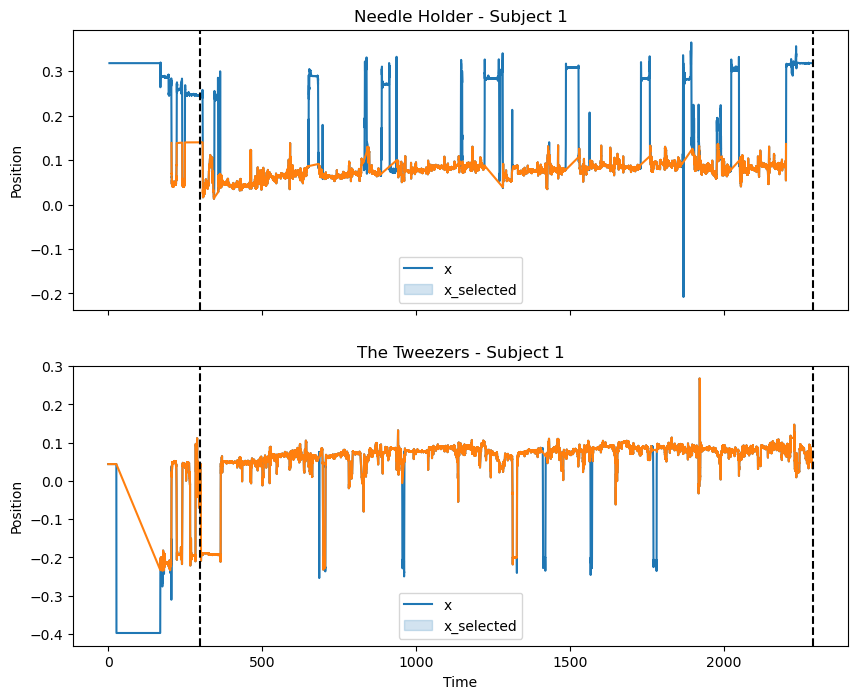

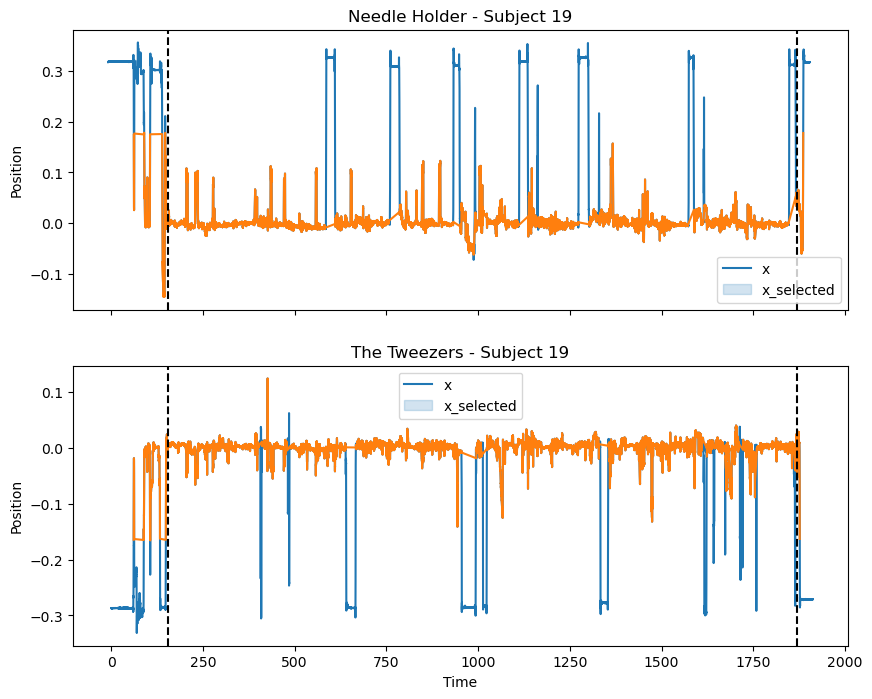

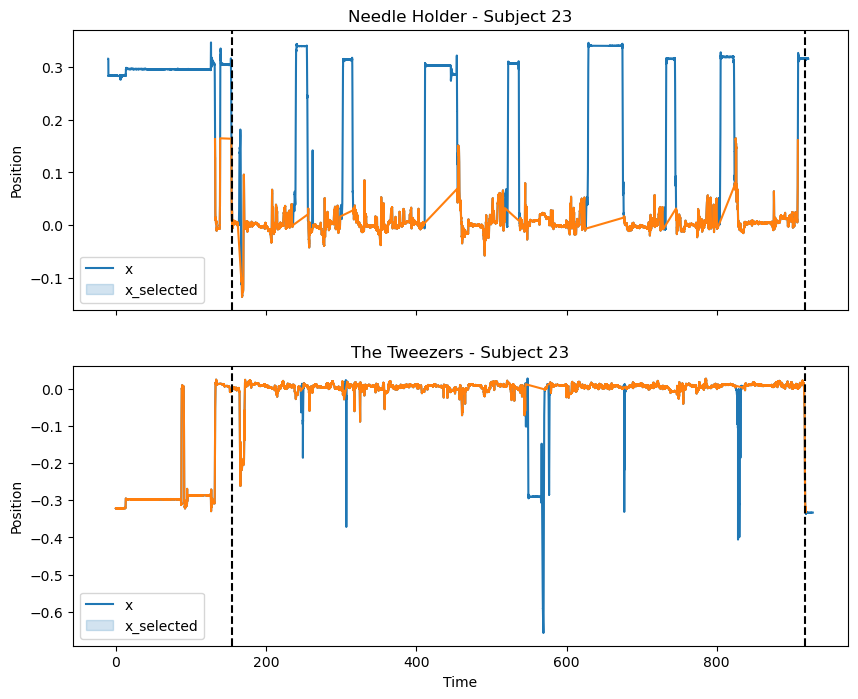

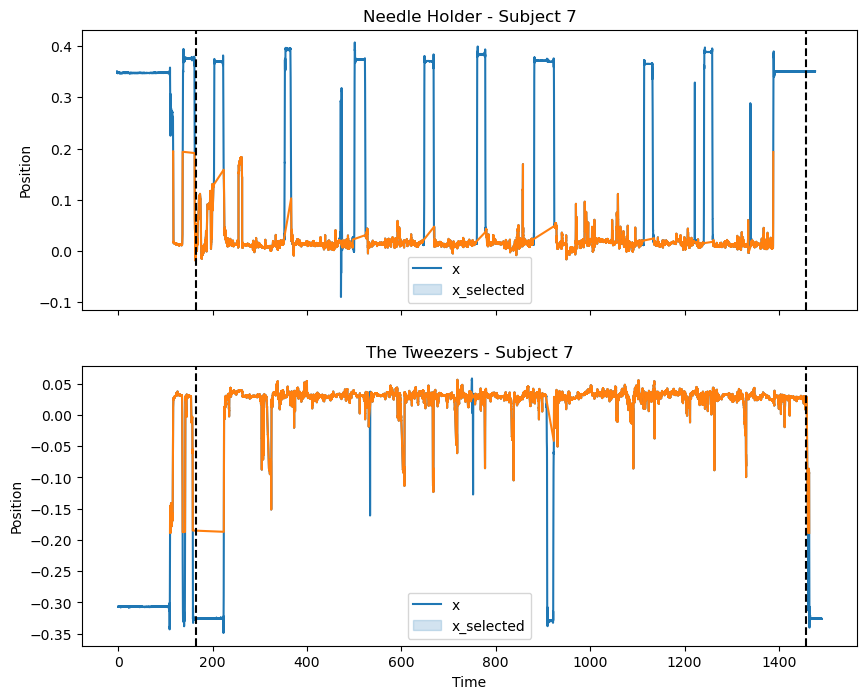

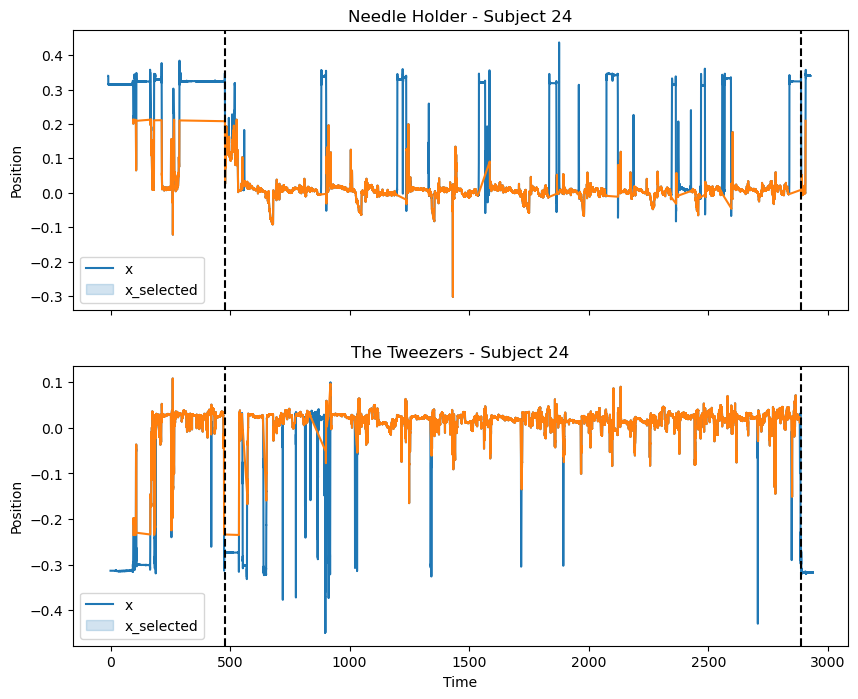

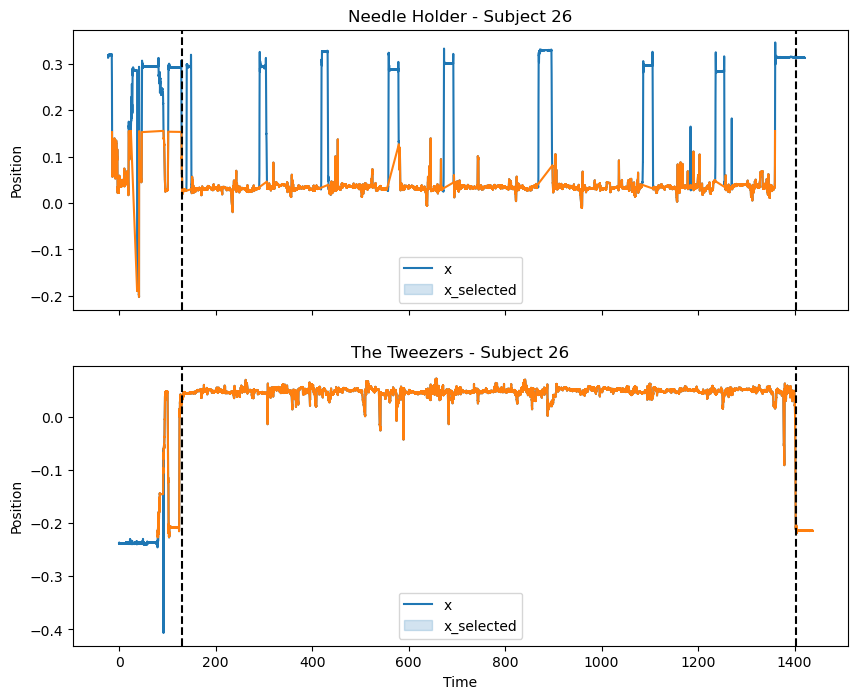

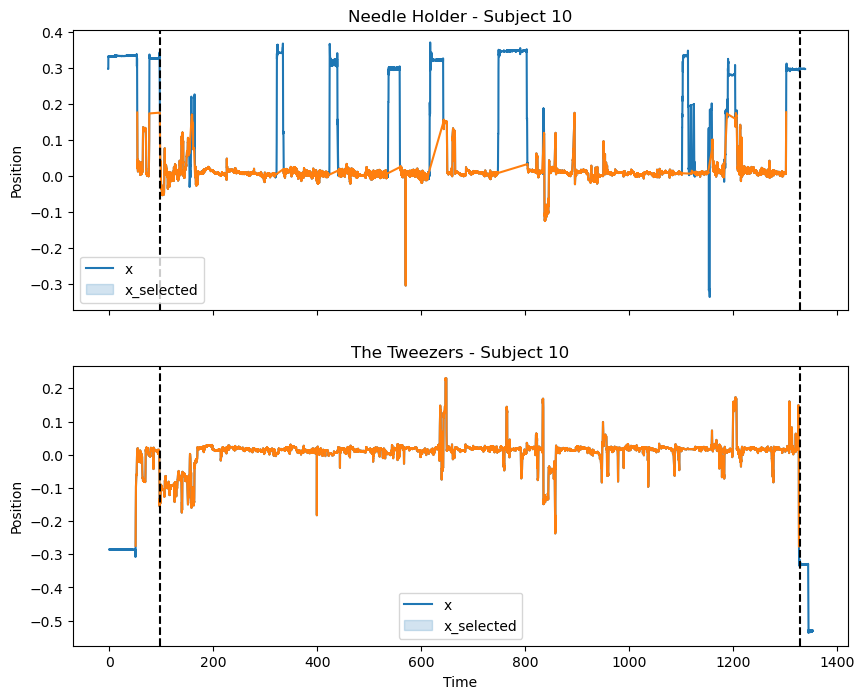

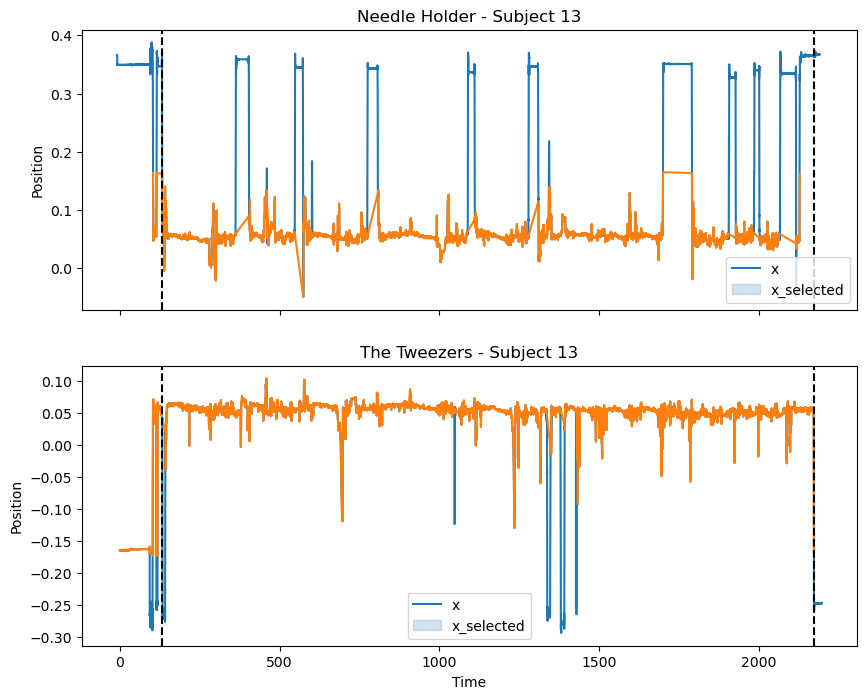

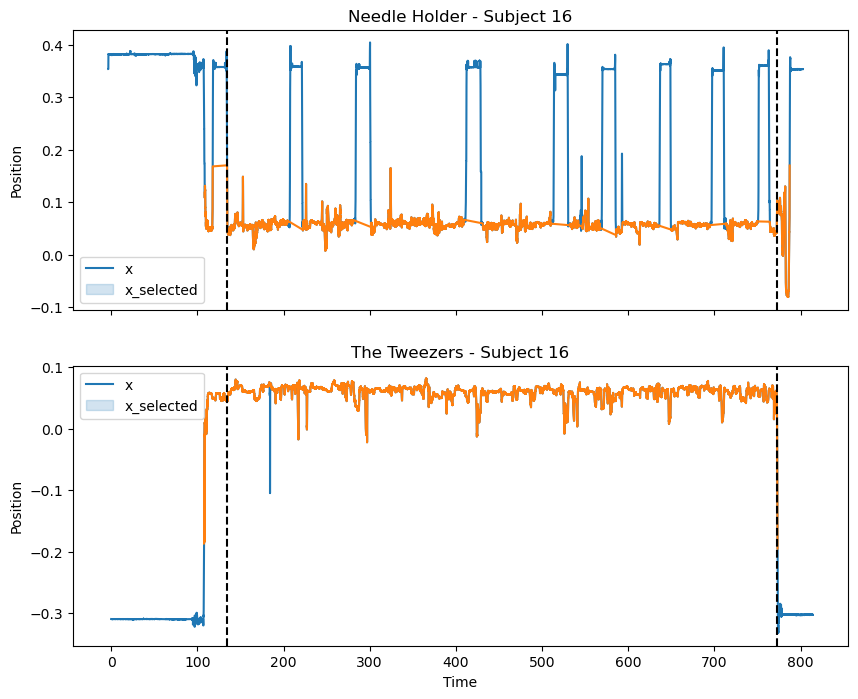

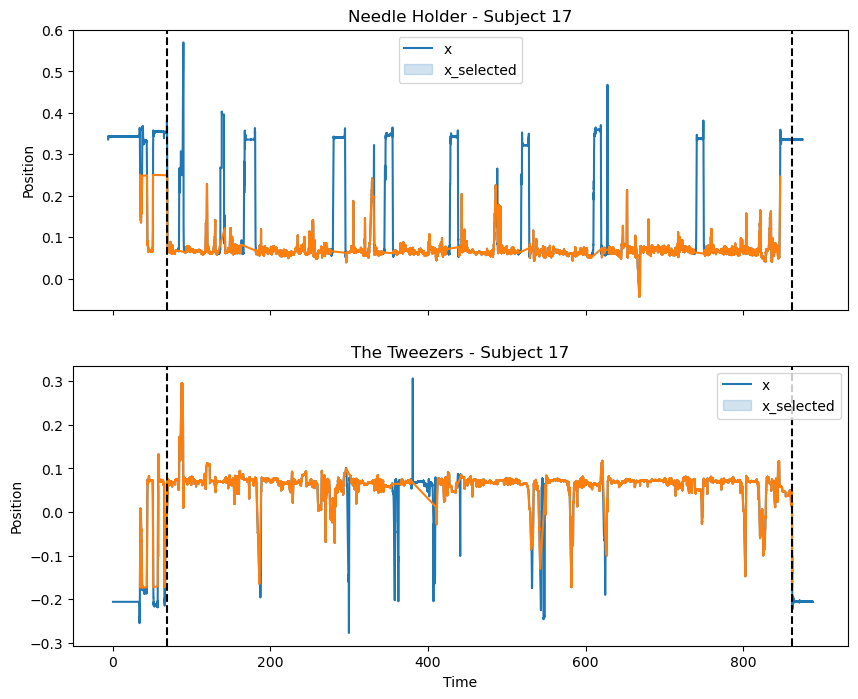

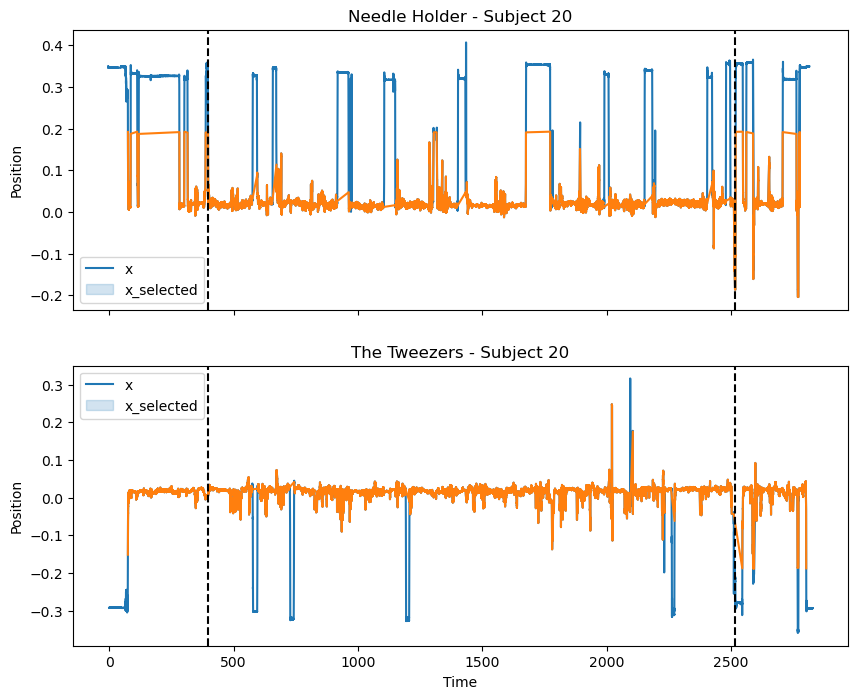

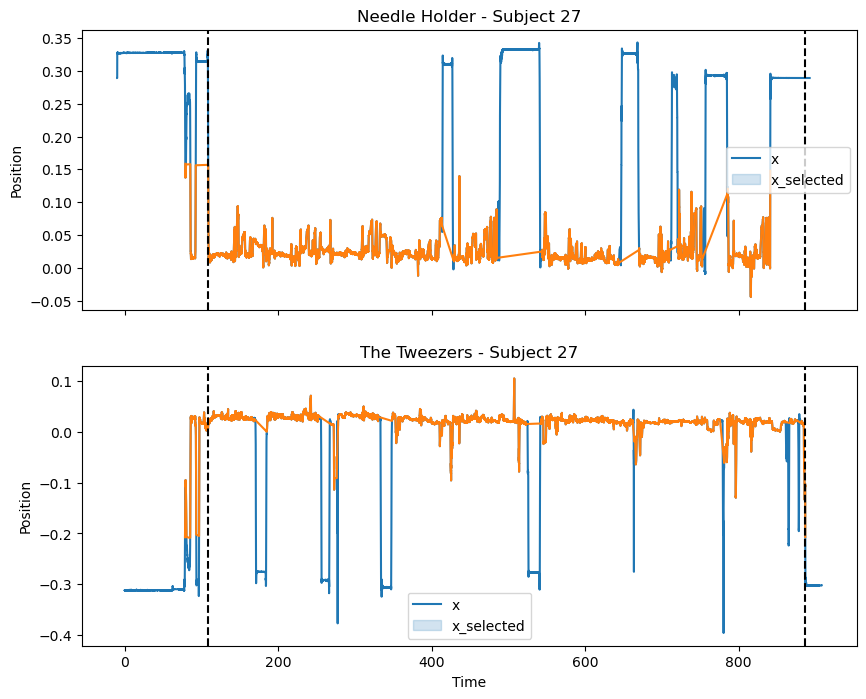

In [10]:
subjects = [1,19, 23,7, 24, 26, 10, 13, 16, 17, 20, 27]

i = 0
for subject in subjects:
    needle_holder_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_NH_reconstructed.csv')
    tweezers_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_TW_reconstructed.csv')

    medians_nh = (needle_holder_rec[['X.1', 'Y.1', 'Z.1']]).median()
    medians_tw = (tweezers_rec[['X.1', 'Y.1', 'Z.1']]).median()

    """Position"""
    selected_xpos_nh, selected_xpos_tw = remove_extreme_using_x_pos(needle_holder_rec, tweezers_rec, prop_nh=0.5, prop_tw=0.5)
    time_event_xpos_nh, time_event_xpos_tw = compute_event_time_x_pos(full_segments_time[i], needle_holder_rec, tweezers_rec, selected_xpos_nh,
                                                                selected_xpos_tw)

    pairs_t_xpos_nh = compute_pairs_time(time_event_xpos_nh[0], time_event_xpos_nh[1])
    pairs_t_xpos_tw = compute_pairs_time(time_event_xpos_tw[0], time_event_xpos_tw[1])

    pairs_adjusted_t_xpos_nh = adjust_time_pair(needle_holder_rec, pairs_t_xpos_nh, medians_nh['X.1'], time_allowed = 6)
    pairs_adjusted_t_xpos_tw = adjust_time_pair(tweezers_rec, pairs_t_xpos_tw, medians_tw['X.1'], time_allowed=6)

    mask_extreme_xpos_event_removed_nh = remove_extreme_using_v_time(needle_holder_rec, pairs_adjusted_t_xpos_nh)
    mask_extreme_xpos_event_removed_tw = remove_extreme_using_v_time(tweezers_rec, pairs_adjusted_t_xpos_tw)

    """Velocity"""
    mask_min_max_nh, mask_min_max_tw = compute_mask_using_v(needle_holder_rec, tweezers_rec, smooth_window=60, prop_nh=0.4, prop_tw=0.4)
    time_event_nh, time_event_tw = compute_event_time(full_segments_time[i], needle_holder_rec, tweezers_rec, mask_min_max_nh[0],  
                                                            mask_min_max_nh[1], mask_min_max_tw[0], mask_min_max_tw[1])

                
    pairs_t_nh = compute_pairs_time(time_event_nh[0], time_event_nh[1])
    pairs_t_tw = compute_pairs_time(time_event_tw[0], time_event_tw[1])

    pairs_adjusted_t_nh = adjust_time_pair(needle_holder_rec, pairs_t_nh, medians_nh['X.1'], time_allowed = 6)
    pairs_adjusted_t_tw = adjust_time_pair(tweezers_rec, pairs_t_tw, medians_tw['X.1'], time_allowed = 6)

    mask_extreme_v_event_removed_nh = remove_extreme_using_v_time(needle_holder_rec, pairs_adjusted_t_nh)
    mask_extreme_v_event_removed_tw = remove_extreme_using_v_time(tweezers_rec, pairs_adjusted_t_tw)

    #mask_extreme_v_event_removed_nh = remove_extreme_using_v_time(needle_holder_rec, pairs_t_nh)
    #mask_extreme_v_event_removed_tw = remove_extreme_using_v_time(tweezers_rec, pairs_t_tw)

    selected_points_nh = needle_holder_rec[mask_extreme_xpos_event_removed_nh & mask_extreme_v_event_removed_nh & selected_xpos_nh]
    selected_points_tw = tweezers_rec[mask_extreme_xpos_event_removed_tw & mask_extreme_v_event_removed_tw & selected_xpos_tw]


    start_t_task = full_segments_time[i]['1'][0]
    end_t_task = full_segments_time[i]['8'][1]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Tracer les données pour 'bh'
    sns.lineplot(x=needle_holder_rec['Time (Seconds)'], y=needle_holder_rec['X.1'], ax=ax1)
    sns.lineplot(x=selected_points_nh['Time (Seconds)'], y=selected_points_nh['X.1'], ax=ax1)
    ax1.axvline(x=start_t_task, color='black', linestyle='--')
    ax1.axvline(x=end_t_task, color='black', linestyle='--')

    """ax1_secondary_y = ax1.twinx()

    sns.lineplot(x=needle_holder_rec['Time (Seconds)'], y=smooth_vx_nh, ax=ax1_secondary_y, color = 'orange')
    ax1_secondary_y.axhline(y=max(smooth_vx_nh)/2, color='black', linestyle='--')
    ax1_secondary_y.set_ylabel('vx_smooth', color='orange')
    ax1_secondary_y.tick_params(axis='y', labelcolor='orange') """

            
    #ax1.set_title(f'Pos and v according to time (Subject {subject}, Needle holder)')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Position')
    ax1.set_title(f'Needle Holder - Subject {subject}')
    ax1.legend(['x', 'x_selected'])


    # Tracer les données pour 'tw'
    sns.lineplot(x=tweezers_rec['Time (Seconds)'], y=tweezers_rec['X.1'], ax=ax2)
    sns.lineplot(x=selected_points_tw['Time (Seconds)'], y=selected_points_tw['X.1'], ax=ax2)
    ax2.axvline(x=start_t_task, color='black', linestyle='--')
    ax2.axvline(x=end_t_task, color='black', linestyle='--')

    ax2.set_xlabel('Time')
    ax2.set_ylabel('Position')
    ax2.legend(['x', 'x_selected'])
    ax2.set_title(f'The Tweezers - Subject {subject}')
    plt.show()

    i = i+1


Plot distribution points in 3D for subject 10

Test Subject 7

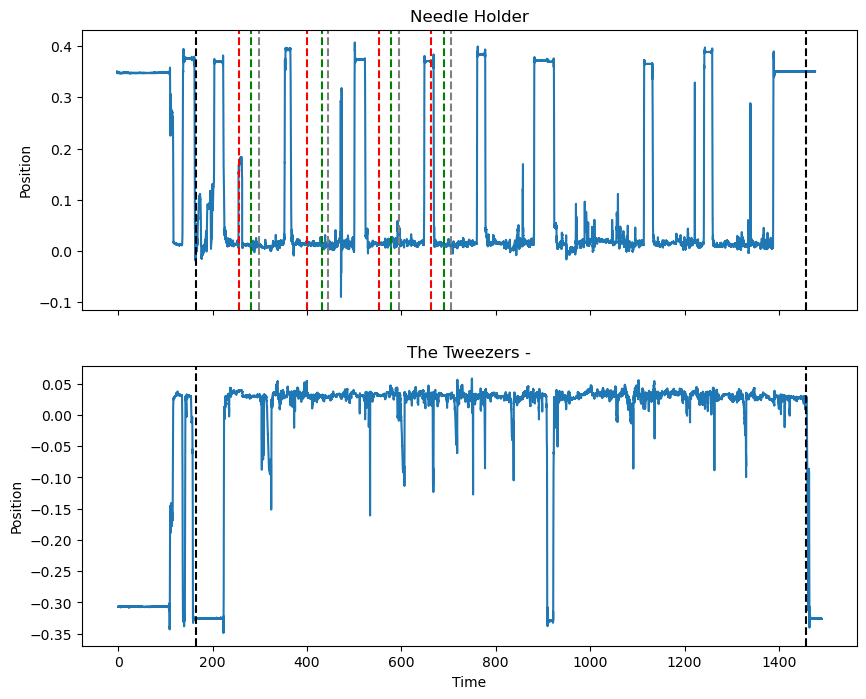

In [11]:
i = 3
needle_holder_rec = pd.read_csv(f'Data/Sync_data/S_{7}_NH_reconstructed.csv')
tweezers_rec = pd.read_csv(f'Data/Sync_data/S_{7}_TW_reconstructed.csv')
start_t_task = full_segments_time[i]['1'][0]
end_t_task = full_segments_time[i]['8'][1]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Tracer les données pour 'bh'
sns.lineplot(x=needle_holder_rec['Time (Seconds)'], y=needle_holder_rec['X.1'], ax=ax1)
ax1.axvline(x=start_t_task, color='black', linestyle='--')
ax1.axvline(x=end_t_task, color='black', linestyle='--')
ax1.axvline(x=298, color='grey', linestyle='--') #front go pro
ax1.axvline(x=445, color='grey', linestyle='--')
ax1.axvline(x=594, color='grey', linestyle='--')
ax1.axvline(x=705, color='grey', linestyle='--')

ax1.axvline(x=282, color='green', linestyle='--') #side go pro
ax1.axvline(x=431, color='green', linestyle='--')
ax1.axvline(x=578, color='green', linestyle='--')
ax1.axvline(x=691, color='green', linestyle='--')

ax1.axvline(x=255, color='red', linestyle='--') #microscope
ax1.axvline(x=401, color='red', linestyle='--')
ax1.axvline(x=552, color='red', linestyle='--')
ax1.axvline(x=662, color='red', linestyle='--')


ax1.set_xlabel('Time')
ax1.set_ylabel('Position')
ax1.set_title('Needle Holder')

sns.lineplot(x=tweezers_rec['Time (Seconds)'], y=tweezers_rec['X.1'], ax=ax2)
ax2.axvline(x=start_t_task, color='black', linestyle='--')
ax2.axvline(x=end_t_task, color='black', linestyle='--')


ax2.set_xlabel('Time')
ax2.set_ylabel('Position')
ax2.set_title(f'The Tweezers -')
plt.show()